# Imports

In [1]:
import folium
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchmetrics
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from sklearn.preprocessing import MinMaxScaler

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from watermark import watermark

# Toolbox

In [2]:
def get_dates():
    today = datetime.now()

    today_rounded_down = today.replace(minute=0, second=0, microsecond=0)

    one_year_ago = today - timedelta(days=365)

    one_year_ago_rounded = one_year_ago.replace(minute=0, second=0, microsecond=0)
    if one_year_ago.minute != 0 or one_year_ago.second != 0 or one_year_ago.microsecond != 0:
        one_year_ago_rounded += timedelta(hours=1)

    formatted_today_rounded_down = today_rounded_down.strftime("%Y-%m-%dT%H:%M:%S")
    formatted_one_year_ago_rounded = one_year_ago_rounded.strftime("%Y-%m-%dT%H:%M:%S")

    return formatted_one_year_ago_rounded, formatted_today_rounded_down

class CustomDataset(Dataset):
    def __init__(self, feature_array, label_array, transform=None):

        self.x = feature_array
        self.y = label_array
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        if self.transform is not None:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return self.y.shape[0]


class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, adam_ = False):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.adam_ = adam_

        self.save_hyperparameters(ignore=['model'])

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = F.mse_loss(logits, true_labels)
        self.log("train_loss", loss)
        return loss  # this is passed to the optimizer for training

    def validation_step(self, batch, batch_idx):
        features, true_labels = batch
        logits = self(features)
        loss = F.mse_loss(logits, true_labels)
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        if self.adam_:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer
    
class PyTorchLSTM_UNI(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PyTorchLSTM_UNI, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

def window(dataset, window_size = 5):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-window_size):
            feature = dataset[i:i+window_size]
            target = dataset[i+window_size:i+window_size+1]
            X.append(feature)
            y.append(target)

        X_r = torch.tensor(np.array(X))
        y_r = torch.tensor(np.array(y))
        return X_r.float(), y_r.float()

def loss_metrics(actual, pred_):
        mse_ = F.mse_loss(torch.tensor(actual.flatten()),
                          torch.tensor(pred_))
        rmse_ = np.sqrt(mse_)

        return mse_, rmse_
    
def compute_mse(model, dataloader, device=None):
    if device is None:
        device = torch.device("cpu")
    model = model.eval()

    mse_loss = 0.0
    total_examples = 0

    with torch.no_grad():
        for idx, (features, labels) in enumerate(dataloader):
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            predictions = model(features)

            # Calculate MSE loss
            mse_loss += F.mse_loss(predictions, labels).item()
            total_examples += features.size(0)

    return mse_loss / total_examples

def predict(model, features, device=None):
    if device is None:
        device = torch.device("cpu")
    model = model.eval()

    with torch.no_grad():
        features = features.to(device)

        # Forward pass
        predictions = model(features)

    return predictions


def rollout(model, current_set, step=24, verbose=True):
        forecast_scaled = []
        if verbose:
            print('Running...')

        with torch.no_grad():
            for i in range(step):
                print(f'{i}/{step}', end='\r')
                prediction = model(current_set.reshape(1, -1)).flatten()
                forecast_scaled.append(prediction.item())
                current_set = current_set[1:]
                current_set = torch.cat((current_set, prediction), dim=0)

            if verbose:
                print('Completed')

            forecast = pd.Series(forecast_scaled)
            results_ = np.array(forecast.values).squeeze()

        return results_  

def rollout_randomforest(model, current_set, step=24, verbose=True):
        forecast_scaled = []
        if verbose:
            print('Running...')

        with torch.no_grad():
            for i in range(step):
                print(f'{i}/{step}', end='\r')
                prediction = model.predict(current_set.reshape(1, -1))
                forecast_scaled.append(prediction.item())
                current_set = current_set[1:]
                current_set = torch.cat((current_set, torch.tensor(prediction)), dim=0)

            if verbose:
                print('Completed')

            forecast = pd.Series(forecast_scaled)
            results_ = np.array(forecast.values).squeeze()

        return results_  

# Data


## Locations of the Wind Farms

In [3]:
# Create a map centered around South Africa
map_sa = folium.Map(location=[-30.5595, 25.0000], zoom_start=6) 

# Add markers for each wind farm
wind_farms = [
    {"name": "Amakhala Emoyeni", "location": [-32.6030, 25.9280]},
    {"name": "Aurora Wind Power", "location": [-32.9141, 17.9911]},
    {"name": "Chaba Wind Farm", "location": [-32.8250, 27.8250]},
    {"name": "Cookhouse Wind Farm", "location": [-32.7494, 25.6931]},
    {"name": "Copperton Windfarm", "location": [-29.9569, 24.7083]},
    {"name": "Dassieklip Wind Energy Facility", "location": [-34.1872, 19.4328]},
    {"name": "Dorper Wind Farm", "location": [-31.4072, 26.3624]},
    {"name": "Excelsior Wind Energy Facility", "location": [-34.0226, 20.4417]},
    {"name": "Garob Wind Farm", "location": [-29.9556, 24.7081]},
    {"name": "Golden Valley Wind", "location": [-32.7955, 25.7254]},
    {"name": "Gouda Wind Project", "location": [-33.3194, 19.1000]},
    {"name": "Grassridge Wind Farm", "location": [-33.7975, 25.6251]},
    {"name": "Jeffreys Bay Wind Farm", "location": [-34.0500, 24.9200]},
    {"name": "Kangnas Wind Farm", "location": [-29.6811, 17.8778]},
    {"name": "Khobab Wind Farm", "location": [-31.3500, 19.7500]},
    {"name": "Kouga Wind Farm", "location": [-34.0472, 24.9225]},
    {"name": "Loeriesfontein 2 Wind Farm", "location": [-30.8865, 19.8085]},
    {"name": "Longyuan Mulilo De Aar Maanhaarberg Wind Energy Facility", "location": [-30.6815, 24.0125]},
    {"name": "Longyuan Mulilo Green Energy De Aar 2 North Wind Energy Facility", "location": [-30.6485, 23.9442]},
    {"name": "Metrowind Van Stadens Wind Farm", "location": [-33.9126, 25.2482]},
    {"name": "Nobelsfontein Phase 1", "location": [-31.3831, 23.1906]},
    {"name": "Nojoli Wind Farm", "location": [-32.8081, 25.6673]},
    {"name": "Noupoort Wind Farm", "location": [-31.6381, 24.8819]},
    {"name": "Nxuba Wind Farm", "location": [-32.7071, 25.7333]},
    {"name": "Oyster Bay Wind Farm", "location": [-34.0261, 24.9467]},
    {"name": "Perdekraal East Wind Farm", "location": [-33.3400, 19.2500]},
    {"name": "Red Cap – Gibson Bay", "location": [-34.0333, 24.9167]},
    {"name": "Roggeveld Wind Farm", "location": [-32.3928, 20.8311]},
    {"name": "Sere Wind Farm", "location": [-31.7500, 18.0833]},
    {"name": "The Karusa Wind Farm", "location": [-32.3906, 20.8242]},
    {"name": "Tsitsikamma Community Wind Farm", "location": [-34.1862, 24.5256]},
    {"name": "Umoya Energy Wind Farm", "location": [-33.0011, 18.3486]},
    {"name": "Waainek Wind Farm", "location": [-33.3042, 26.5247]},
    {"name": "Wesley-Ciskei", "location": [-34.0167, 26.5333]}
]

wind_farms_df = pd.DataFrame(wind_farms)
wind_farms_df[['latitude', 'longitude']] = pd.DataFrame(wind_farms_df['location'].tolist())
wind_farms_df.drop('location', axis=1, inplace=True)
wind_farms_df = wind_farms_df.set_index('name')

for farm in wind_farms:
    folium.Marker(location=farm["location"], popup=farm["name"]).add_to(map_sa)

# Save the map to an HTML file
map_sa
# map_sa.save("data\wind_farms_sa_map.html")

## OpenWeatherMap API Request Setup

In [4]:
import requests

latitude = -32.6030
longitude = 25.9280
# Define the API key and base URL
api_key = '7552f271b24168a6c4ef09611a862ff8'
base_url = f'https://api.openweathermap.org/data/2.5/weather'


## Gets the current hour's weather data for each of the Wind Farms

In [5]:
needed = False

if needed:

    weather_data = []
    count = 1


    for farm in wind_farms:
        print(f'{count}/{len(wind_farms)}', end='\r')
        count += 1

        farm_name = farm["name"]
        latitude, longitude = farm["location"]

        # Make the API request
        params = {
            'lat': latitude,
            'lon': longitude,
            'appid': api_key,
            'units': 'metric'  # Get data in metric units (Celsius, meters/sec, etc.)
        }
        response = requests.get(base_url, params=params)

        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            weather_info = {
                'Farm Name': farm_name,
                'Temperature (°C)': data['main']['temp'],
                'Description': data['weather'][0]['description'],
                'Wind Speed (m/s)': data['wind']['speed'],
                'Wind Direction': data['wind']['deg'],
                'Humidity (%)': data['main']['humidity']
            }
            weather_data.append(weather_info)
        else:
            print(f"Failed to retrieve weather data for {farm_name}. Status code:", response.status_code)

    # Create a DataFrame from the list of weather data
    weather_df = pd.DataFrame(weather_data)


    # Add current timestamp as index
    weather_df.index = [pd.Timestamp.now().replace(minute=0, second=0, microsecond=0)] * len(weather_df)

    # Display the DataFrame
    weather_df.head()


## Gets the historic data for a specific wind farms

Not needed


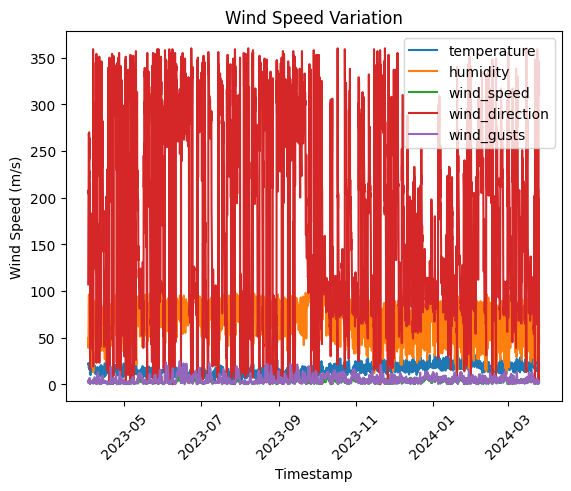

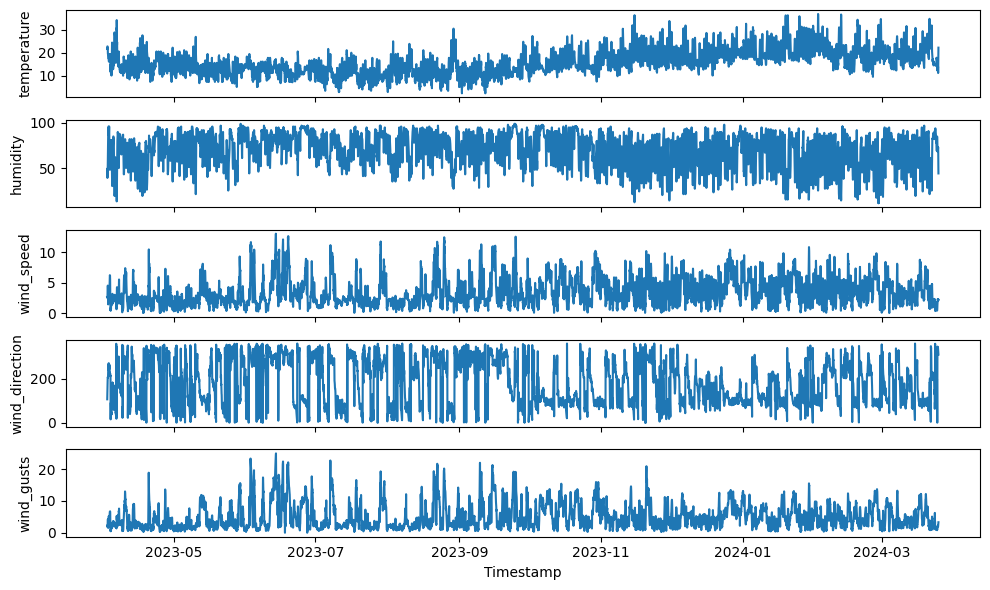

In [6]:
needed = False

if needed:
    farm = 'Dassieklip Wind Energy Facility'

    latitude = wind_farms_df.loc[farm]['latitude']
    longitude = wind_farms_df.loc[farm]['longitude']

    weather_data = []

    start_timestamp_iso, end_timestamp_iso = get_dates()
    end_timestamp_unix = int(datetime.fromisoformat(end_timestamp_iso).timestamp())
    start_timestamp_unix = int(datetime.fromisoformat(start_timestamp_iso).timestamp())

    weeks = 52

    for i in range(weeks):
        print(f'Progress: {i}/{weeks}', end='\r')
        start_timestamp_unix += 604800
        end_timestamp_unix = start_timestamp_unix + 604800
        

        url = f'https://history.openweathermap.org/data/2.5/history/city?lat={latitude}&lon={longitude}&start={start_timestamp_unix}&end={end_timestamp_unix}&appid={api_key}&units=metric'

        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()

            
            for item in data['list']:
                timestamp = item['dt']
                datetime_obj = datetime.utcfromtimestamp(timestamp)
                timestamp_iso = datetime_obj.isoformat()
                temperature = item['main']['temp']
                humidity = item['main']['humidity']
                wind_speed = item['wind']['speed']
                wind_direction = item['wind']['deg']
                try:
                    wind_gusts = item['wind']['gust']
                except:
                    wind_gusts = 0
                weather_data.append({'timestamp': timestamp_iso, 'temperature': temperature, 
                                    'humidity': humidity, 'wind_speed': wind_speed, 
                                    'wind_direction': wind_direction, 'wind_gusts' : wind_gusts})
        
            weather_df = pd.DataFrame(weather_data)
            weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])
            weather_df.set_index('timestamp', inplace=True)
        else:
            # Print an error message if the request was unsuccessful
            print(f"Error: {response.status_code}")
            print(url)

    weather_df.to_csv('data/current_weather_data.csv')

    print('Gathered data')
else:
    weather_df = pd.read_csv('data/current_weather_data.csv', index_col='timestamp', parse_dates=True)
    print('Not needed')

plt.plot(weather_df)
plt.xlabel('Timestamp')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Variation')
plt.legend(weather_df.columns)
plt.xticks(rotation=45)
plt.show()

fig, axes = plt.subplots(nrows=len(weather_df.columns), ncols=1, figsize=(10, 6), sharex=True)

# Plot each feature
for i, column in enumerate(weather_df.columns):
    axes[i].plot(weather_df.index, weather_df[column], label=column)
    axes[i].set_ylabel(column)

# Set common x-axis label
axes[-1].set_xlabel('Timestamp')

plt.tight_layout()
plt.show()



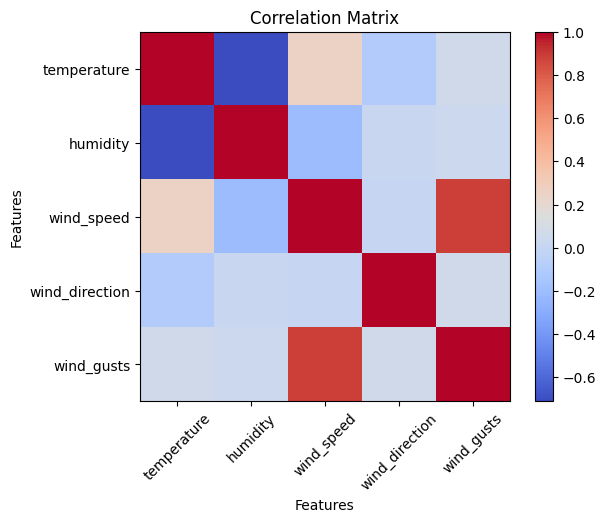

In [7]:
import matplotlib.pyplot as plt

correlation_matrix = weather_df.corr()

plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.show()


# Preparing the data

In [8]:
seed = 0
window_size = 24 * 3

scaler = MinMaxScaler()

scaler.fit(weather_df['wind_speed'].values.reshape(-1, 1))


MinMaxScaler()

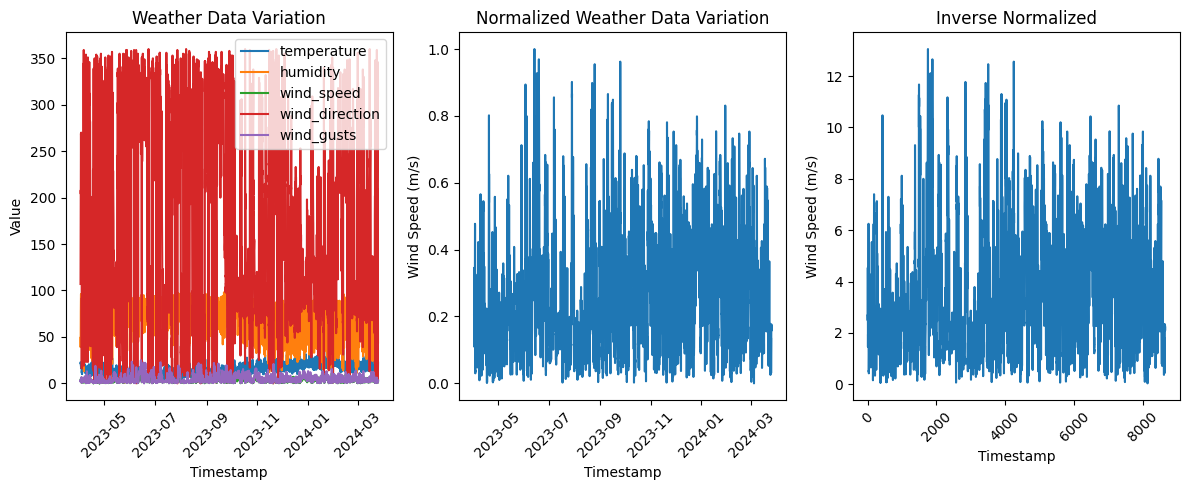

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

axes[0].plot(weather_df)
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Value')
axes[0].set_title('Weather Data Variation')
axes[0].legend(weather_df.columns)
axes[0].tick_params(axis='x', rotation=45)

norm_df = pd.DataFrame(scaler.fit_transform(weather_df['wind_speed'].values.reshape(-1, 1)), index=weather_df.index)

axes[1].plot(norm_df)  
axes[1].set_xlabel('Timestamp')
axes[1].set_ylabel('Wind Speed (m/s)')
axes[1].set_title('Normalized Weather Data Variation')
axes[1].tick_params(axis='x', rotation=45)

unnorm_df = pd.DataFrame(scaler.inverse_transform(norm_df))

axes[2].plot(unnorm_df)
axes[2].set_xlabel('Timestamp')
axes[2].set_ylabel('Wind Speed (m/s)')
axes[2].set_title('Inverse Normalized')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()



# Models

## Data Module

In [10]:
class WeatherDataModule(L.LightningDataModule):
    def __init__(self, data_dir="data\current_weather_data.csv", index_='timestamp', 
                 column=2, batch_size=64, window_size=5, normalize_=True,
                 date_range = None, step_ = 24):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.index_ = index_
        self.column = column
        self.date_range = date_range
        self.window_size = window_size
        self.step_ = step_

        self.normalize_ = normalize_

    def prepare_data(self):
        df_ = pd.read_csv(self.data_dir, index_col=self.index_, parse_dates=True)
        if self.date_range != None:
            df_ = df_[self.date_range]
        
        if self.column == None:
            self.df = df_
        else:
            self.df = df_.iloc[:,self.column]
        
        if self.normalize_:
            self.scaler = MinMaxScaler()
            self.scaler.fit(self.df.values.reshape(-1, 1))
            self.df = self.normalize(self.df)

        self.windows, self.targets = self.window_step(self.df, self.step_)
        self.windows, self.targets = self.windows.squeeze(), self.targets.squeeze()

    def window_step(self, dataset, step_ ):
        """Transform a time series into a prediction dataset
        
        Args:
            dataset: A numpy array of time series, first dimension is the time steps
            lookback: Size of window for prediction
        """
        X, y = [], []
        for i in range(len(dataset)-self.window_size - step_):
            feature = dataset[i:i+self.window_size]
            target = dataset[i+self.window_size:i+self.window_size+step_]
            X.append(feature)
            y.append(target)

        X_r = torch.tensor(np.array(X))
        y_r = torch.tensor(np.array(y))
        return X_r.float(), y_r.float()
    
    def normalize(self, series):
        return pd.DataFrame(self.scaler.fit_transform(series.values.reshape(-1, 1)), index=series.index)
    
    def inverse_normalze(self, series):
        return pd.DataFrame(self.scaler.inverse_transform(series.values.reshape(-1, 1)), index=series.index)

    def setup(self, stage: str):
        split = [round(len(self.targets) * 0.7), round(len(self.targets) * 0.9)]

        self.f_train, self.t_train = self.windows[:split[0]], self.targets[:split[0]]
        self.f_valid, self.t_valid = self.windows[split[0]:split[1]], self.targets[split[0]:split[1]]
        self.f_test, self.t_test = self.windows[split[1]:], self.targets[split[1]:]

        print(f'Train: {self.f_train.shape}\nValid: {self.f_valid.shape}\nTest: {self.f_test.shape}')

    def train_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(TensorDataset(self.f_train, self.t_train), batch_size=self.batch_size, shuffle=False)

    # def predict_dataloader(self):
    #     return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=False)


## Training

In [11]:
window_size = 24 * 3
step = 24

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(watermark(packages="torch,lightning", python=True))
print("Torch CUDA available?", torch.cuda.is_available())

dm = WeatherDataModule(window_size=window_size, batch_size=32, step_=step)

train_lstm = False
train_RFR = True

hidden_LSTM = [8,3]

if train_lstm:
    early_stop_callback = EarlyStopping(
        monitor="val_loss", 
        min_delta=0.0002, 
        patience=5, 
        verbose=False, 
        mode="min",
        )

    

    model_lstm = PyTorchLSTM_UNI(input_size = window_size, hidden_size = hidden_LSTM[0], num_layers = hidden_LSTM[1], output_size = step)
    lightning_model = LightningModel(model=model_lstm, learning_rate=0.004, adam_=True)

    trainer = L.Trainer(
        max_epochs=15,
        callbacks=[early_stop_callback],
        accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
        devices="auto",  # Uses all available GPUs if applicable
    )

    trainer.fit(
        model=lightning_model,
        datamodule=dm,
    )

    PATH = "LSTM.pt"
    torch.save(model_lstm.state_dict(), PATH)

if train_RFR:
    dm.prepare_data()
    dm.setup('')
    if True:
        print('Training Random Forest Regressor...')
        rf_regressor_1 = RandomForestRegressor(n_estimators=100, random_state=42)
        

        rf_regressor_1.fit(dm.f_train, dm.t_train)
    if True:
        print('Training XGBoost Regressor...')
        rf_regressor_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', learning_rate=0.01,
                                                max_depth=3, n_estimators=1000,
                                                objective='reg:linear', random_state=0)

        rf_regressor_xgb.fit(dm.f_train, dm.t_train, eval_set=[(dm.f_valid, dm.t_valid)], early_stopping_rounds=10, verbose=False)

    if True:
        print('Training KNN Regressor...')
        knn_regressor = KNeighborsRegressor(n_neighbors=10) 
        knn_regressor.fit(dm.f_train, dm.t_train.squeeze())

    

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

torch    : 2.2.1
lightning: 2.2.1

Torch CUDA available? False
Train: torch.Size([5983, 72])
Valid: torch.Size([1709, 72])
Test: torch.Size([855, 72])
Training Random Forest Regressor...
Training XGBoost Regressor...


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:15:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Training KNN Regressor...


# Results

In [12]:
plot_lstm = True
plot_RFR = False
seed = 0

In [13]:
seed += 12
step = 24

X_ = dm.f_valid
y_ = dm.t_valid
weather_df = pd.DataFrame()
if dm.normalize_:
    weather_df['wind_speed'] = dm.inverse_normalze(dm.df[dm.f_train.shape[0]:dm.f_train.shape[0] + dm.f_valid.shape[0]])
else:
    weather_df['wind_speed'] = dm.df[dm.f_train.shape[0]:dm.f_train.shape[0] + dm.f_valid.shape[0]]

# Load models

if plot_lstm:
    model_lstm = PyTorchLSTM_UNI(input_size = window_size, hidden_size = hidden_LSTM[0], num_layers = hidden_LSTM[1], output_size = step)
    model_lstm.load_state_dict(torch.load(PATH))
    model_lstm.eval()

all = False

# Plot Models

if all:
    x_lin = np.array(range(window_size + 1))

    
    # predictions = predict(model, X_)

    plt.plot(weather_df.index, weather_df['wind_speed'], label = 'Actual') # [seed:seed + window_size]
    # plt.plot(weather_df.index[window_size:], predictions, label = 'Prediction', c='red')
else:
    plt.plot(weather_df.index[seed:seed  + window_size], weather_df[seed:seed + window_size]['wind_speed'], c='cyan', label = 'Windowed Input')
    plt.plot(weather_df.index[seed + window_size:seed + step + window_size], weather_df[seed + window_size:seed + step + window_size]['wind_speed'], c='blue', label = 'Actual') 
    
    if plot_lstm:
        predictions = predict(model_lstm, X_[seed:seed + 1]).squeeze()

        if dm.normalize_:
            predictions = np.array(dm.inverse_normalze(pd.Series(predictions)))

        plt.plot(weather_df.index[window_size + seed:seed + step + window_size], predictions, label = f'{step}-step Rollout', c='orange')

        print('\nModel LSTM:\n')
        mse, rmse = loss_metrics(np.array(weather_df[seed + window_size:seed + step + window_size]['wind_speed']), predictions)
        print(f'Single Step:\tMSE: {mse:2f}\t\tRMSE: {rmse:2f}')

    if plot_RFR:
        predictions_RFR = rf_regressor_1.predict(X_[seed].reshape(1, -1))

        if dm.normalize_:
            predictions_RFR = np.array(dm.inverse_normalze(pd.Series(predictions_RFR.squeeze())))

        plt.plot(weather_df.index[window_size + seed:seed + step + window_size], predictions_RFR, label = 'RFR Prediction', c='brown')

        print('\nModel RFR:\n')
        mse, rmse = loss_metrics(np.array(weather_df[seed + window_size:seed + step + window_size]['wind_speed']), predictions_RFR)
        print(f'Single Step:\tMSE: {mse:2f}\t\tRMSE: {rmse:2f}')

plt.title('Visual Inspection Model')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

NameError: name 'PATH' is not defined

# Testing

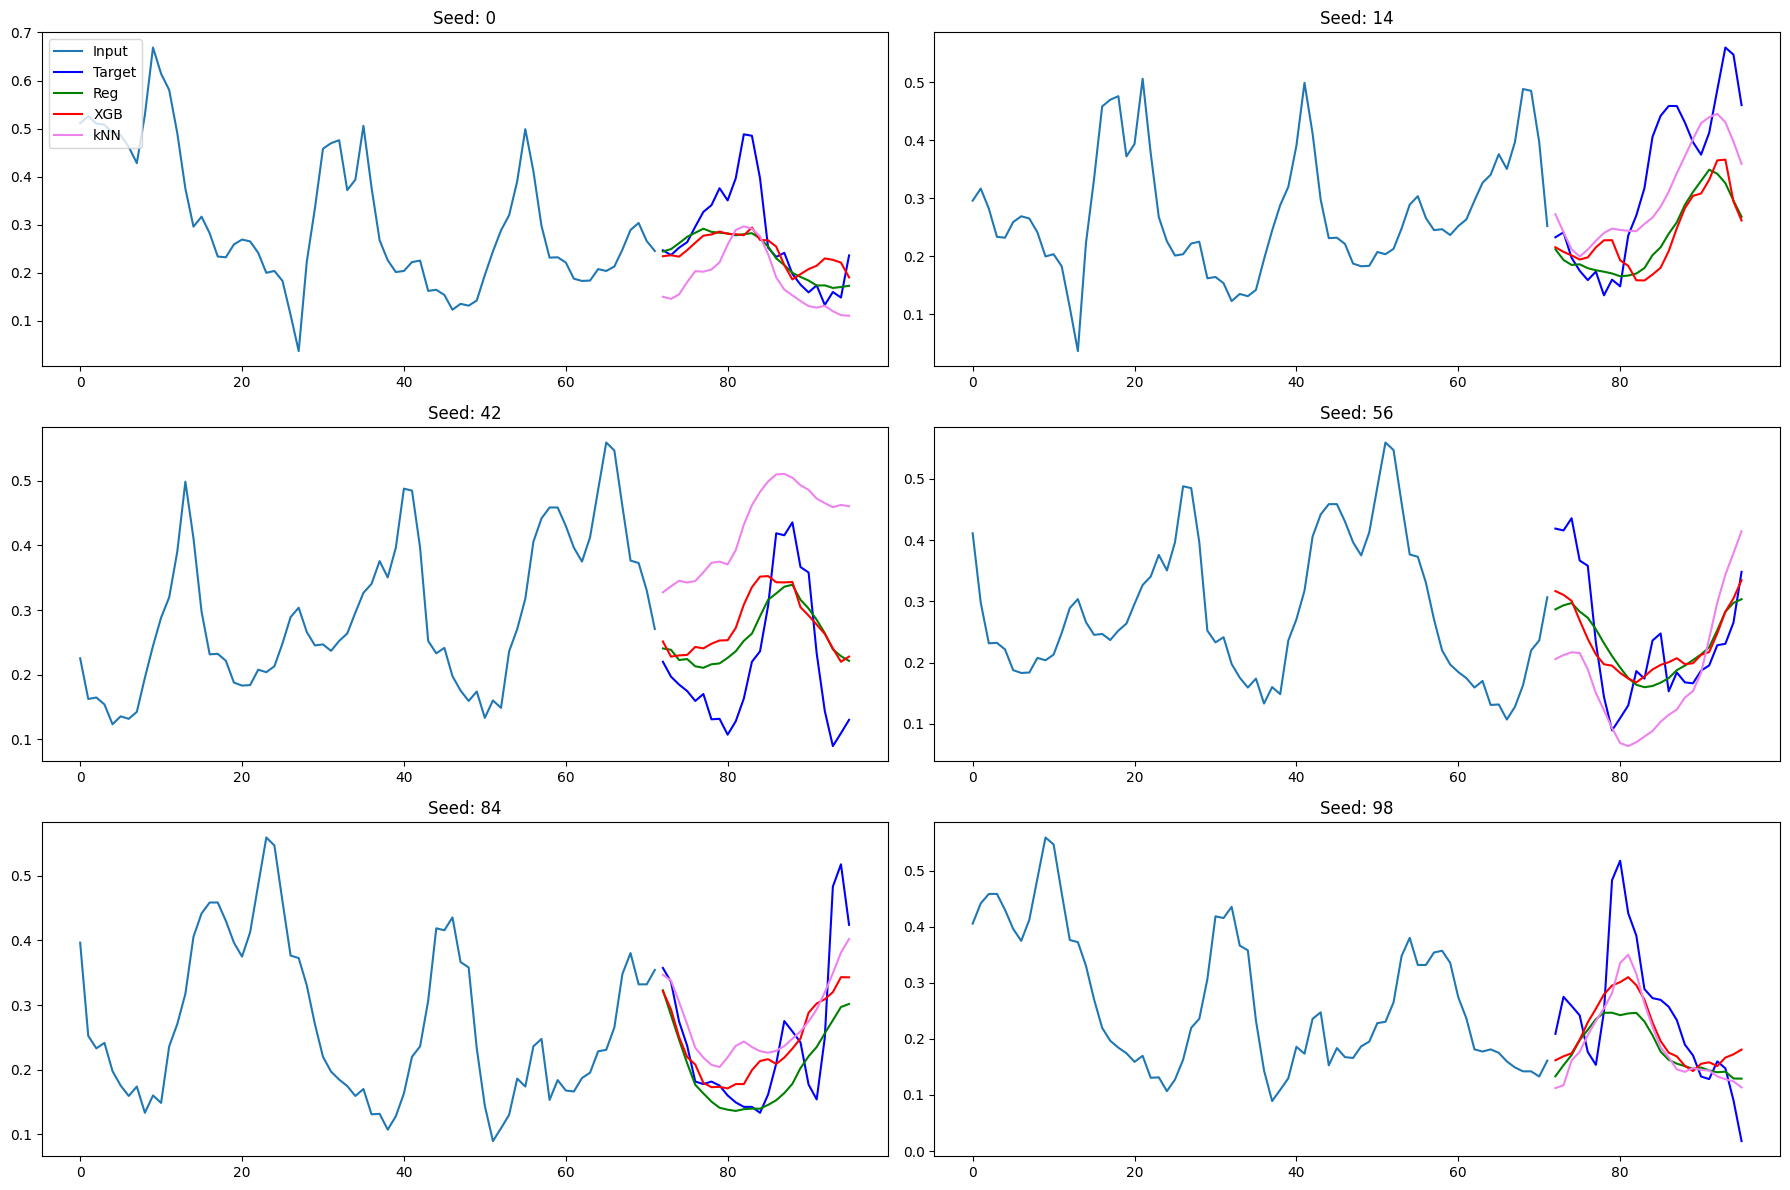

Mean MSE for Random Forest: 0.008778104372768913
Mean MSE for XGBoost: 0.009023833
Mean MSE for kNN: 0.015713234


In [ ]:
mse_rfr = []
mse_xgb = []
mse_knn = []

fig, axes = plt.subplots(3, 2, figsize=(18, 12))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        seed_index = i * 3 + j
        seed = seed_index * 14  # Increment seed with 2 each time
        current_data = dm.f_valid[seed]
        step_pred_rfr = rf_regressor_1.predict(current_data.reshape(1, -1)).squeeze()
        step_pred_xgb = rf_regressor_xgb.predict(current_data.reshape(1, -1)).squeeze()
        step_pred_knn = knn_regressor.predict(current_data.reshape(1, -1)).squeeze()
        # step_pred_lstm = predict(model_lstm, current_data.reshape(1, -1)).squeeze()
        t_test_data = dm.t_valid[seed:seed + step][0]

        ax.plot(range(window_size), current_data, label = 'Input')
        ax.plot(range(window_size, window_size + step), t_test_data, label = 'Target', c='blue')
        ax.plot(range(window_size, window_size + step), step_pred_rfr, label = 'Reg', c='green')
        ax.plot(range(window_size, window_size + step), step_pred_xgb, label = 'XGB', c='red')     
        ax.plot(range(window_size, window_size + step), step_pred_knn, label = 'kNN', c='violet')                
        # ax.plot(range(window_size, window_size + step), step_pred_lstm, label = 'LSTM')

        mse_rfr.append(mean_squared_error(t_test_data, step_pred_rfr))
        mse_xgb.append(mean_squared_error(t_test_data, step_pred_xgb))
        mse_knn.append(mean_squared_error(t_test_data, step_pred_knn))

        if i == 0 and j == 0:  
            ax.legend(loc='upper left')

        ax.set_title(f"Seed: {seed}")

plt.tight_layout()
plt.show()

mean_rfr = np.mean(mse_rfr)
mean_xgb = np.mean(mse_xgb)
mean_knn = np.mean(mse_knn)

print("Mean MSE for Random Forest:", mean_rfr)
print("Mean MSE for XGBoost:", mean_xgb)
print("Mean MSE for kNN:", mean_knn)

# Synthetic Data

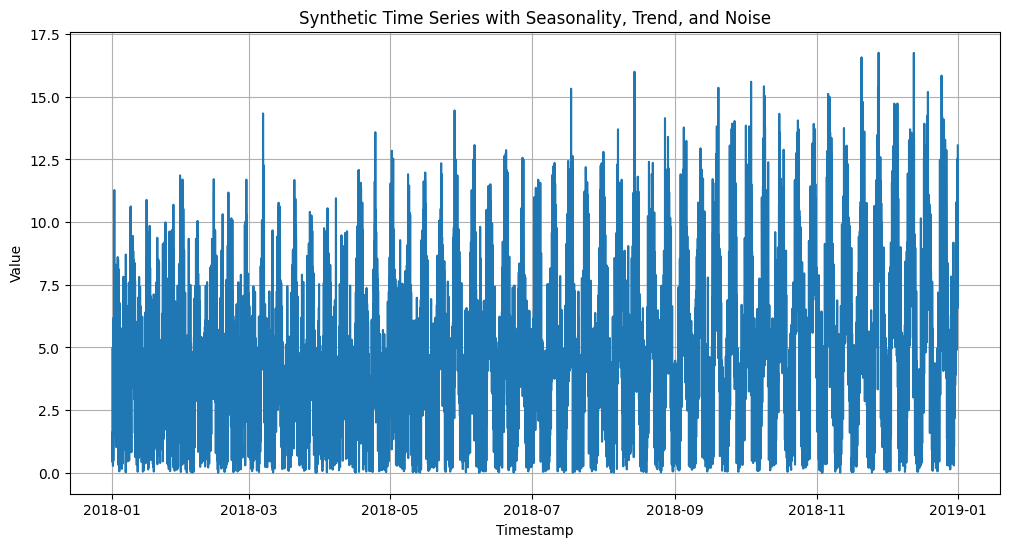

In [ ]:

start_date = '2018-01-01 00:00:00'
end_date = '2018-12-31 23:59:59'
num_samples = 365 * 24  # 1 year with hourly data
trend_slope = 0.001
seasonality_amplitude = 10
noise_std = 5

# Generate timestamps
timestamps = pd.date_range(start=start_date, end=end_date, freq='h')

# Generate trend
trend = np.arange(num_samples) * trend_slope

# Generate seasonality
seasonality = seasonality_amplitude * np.sin(2 * np.pi * np.arange(num_samples) / (24 * 7))

# Generate noise
noise = np.random.normal(scale=noise_std, size=num_samples)

# Combine trend, seasonality, and noise to create the time series
time_series = trend + seasonality + noise

time_series = abs(time_series / 2 + 1)

df = pd.DataFrame(data={'wind_speed': time_series}, index=timestamps)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(timestamps, time_series)
plt.title('Synthetic Time Series with Seasonality, Trend, and Noise')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# df.to_csv('Synth_Hourly_V02.csv')